# FERMI: Fault nEtwoRks ModellIng

NOTES:
- We need to consider the cases where the kite fault surface contains some NaN (this is possible in case of irregular surfaces)
- get_section_polygon will also need to be updated to account for NaN

In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
import pygmt
from numba import jit
import geojson
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from openquake.hazardlib.geo import Point, Line
from openquake.hazardlib.geo.surface.kite_fault importa (
    get_profiles_from_simple_fault_data, KiteSurface)
from openquake.hazardlib.tests.geo.surface.kite_fault_test import plot_mesh_2d
from openquake.hazardlib.geo.mesh import Mesh
from openquake.hazardlib.geo.geodetic import geodetic_distance

PI = 3.1415926535
EARTH_RADIUS = 6371.0

## Settings 

In [3]:
general_interaction_distance = 10.0
interaction_distance = 5.0
nc_strike = 2
nc_dip = 4
nc_dip = 11

In [4]:
def plot_mesh_2d(ax, smsh):
    """
    Plots the mesh
    """
    for i in range(smsh.mesh.lons.shape[0]):
        ax.plot(smsh.mesh.lons[i, :], smsh.mesh.lats[i, :], '-r', lw=0.5)
    for i in range(smsh.mesh.lons.shape[1]):
        ax.plot(smsh.mesh.lons[:, i], smsh.mesh.lats[:, i], '-r', lw=0.5)
    ax.plot(smsh.mesh.lons[0, :], smsh.mesh.lats[0, :], '-g', lw=1.0)

In [5]:
def get_dip_dir(prop: dict):
    """
    :param prop:
        A dictionary with the properties of a feature
    """
    
    if (isinstance(prop["dip_dir"], float) or
        isinstance(prop["dip_dir"], int)):
        return float(prop["dip_dir"])
    else:
        if prop["dip_dir"] == 'N':
            return 0
        elif prop["dip_dir"] == 'E':
            return 90
        elif prop["dip_dir"] == 'S':
            return 180
        elif prop["dip_dir"] == 'W':
            return 270
        elif prop["dip_dir"] == 'NE':
            return 45
        elif prop["dip_dir"] == 'SE':
            return 135
        elif prop["dip_dir"] == 'SW':
            return 225
        elif prop["dip_dir"] == 'NW':
            return 315
        else:
            msg = 'Unknown definition of dir direction'
            raise ValueError()   
            
def fix_right_hand(trace, dip_dir):
    azi = trace.average_azimuth()
    if np.abs((azi + 90) % 360 - dip_dir) < 60:
        return trace
    else:
        return trace.flip

## Read input information and create the kite surfaces

In [6]:
fname = 'sample.geojson'

In [7]:
# Read .geojson file with fault info
with open(fname) as f:
    data = geojson.load(f)

In [8]:
gdf = gpd.read_file(fname)

In [9]:
# Creates the surfaces
surfs = []
edge_sd = 2.0
traces = []
for fea in data['features']:
    geom = fea['geometry']
    prop = fea['properties']
    dip_dir = get_dip_dir(prop)
    dip = prop.get("dip", None)
    fault_trace = Line([Point(c[0], c[1]) for c in geom["coordinates"]])
    fault_trace = fix_right_hand(fault_trace, dip_dir)
    trace = traces.append(
        [[p.longitude, p.latitude] for p in fault_trace.points])
    num = np.round(fault_trace.get_length() / edge_sd)
    edge_sd_res = fault_trace.get_length() / num
    upp_sd = prop.get("usd", None)
    low_sd = prop.get("lsd", None)
    profs = get_profiles_from_simple_fault_data(
        fault_trace, upp_sd, low_sd, dip, 2.0)
    surf = KiteSurface.from_profiles(profs, profile_sd=2.0, edge_sd=edge_sd_res)
    surfs.append(surf)

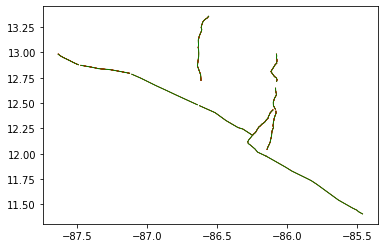

In [10]:
fig, ax = plt.subplots(1, 1)
for surf in surfs:
    plot_mesh_2d(ax, surf)

In [62]:
def split_mesh_into_sections(mesh, nc_strike=-1, nc_dip=-1):
    """
    This splits a mesh (we assume this is a mesh representing a 
    kite surface) into a number of sections. 

    :param mesh:
        An :class:`openquake.hazardlib.geo.mesh.Mesh` instance
    :param nc_strike:
        Number of cells along strike defining a section
    :param nc_dip:
        Number of cells along dip defining a section
    """
    # Set the default number of cells when this info is not 
    # provided. We assume that sections are rupturing the 
    # whole seismogenic layer and the lenght is half the 
    # width
    if nc_dip < 0:
        if nc_dip == -1:
            nc_dip = mesh.shape[0]
    # This collects the upper left corner of each section 
    # defined on this fault surface
    sections_ul = []
    for irow in range(0, mesh.shape[0], nc_dip):
        for icol in range(0, mesh.shape[1], nc_strike):
            sections_ul.append([irow, icol])
    return sections_ul, [nc_strike, nc_dip]      
    

def get_mesh_bb(mesh):
    return [np.min(mesh.lons), np.max(mesh.lons),
            np.min(mesh.lats), np.max(mesh.lats)]

def get_surfaces_bbs(surfs):
    bbs = []
    for surf in surfs:
        bbs.append(get_mesh_bb(surf.mesh))
    return bbs
        
def get_poly_from_bb(bb):
    vtxs = []
    vtxs.append([bb[0], bb[2]])  # LL
    vtxs.append([bb[1], bb[2]])  # LR
    vtxs.append([bb[1], bb[3]])  # UR
    vtxs.append([bb[0], bb[3]])  # UR
    return np.array(vtxs)

def get_bb_distance(bb1, bb2):
    """
    See shorturl.at/CWY57
    """
    # def rect_distance((x1, y1, x1b, y1b), (x2, y2, x2b, y2b)):
    x1 = bb1[0]
    y1 = bb1[2]
    x1b = bb1[1]
    y1b = bb1[3]
    
    x2 = bb2[0]
    y2 = bb2[2]
    x2b = bb2[1]
    y2b = bb2[3]
    
    left = x2b < x1  # Second bb is left of the first one
    right = x1b < x2  # Second bb is right of the first one
    bottom = y2b < y1  # Second bb is below  the first one
    top = y1b < y2  # Second bb is above the first one
    
    if top and left:
        return geodetic_distance(x1, y1b, x2b, y2)
    elif left and bottom:
        return geodetic_distance(x1, y1, x2b, y2b)
    elif bottom and right:
        return geodetic_distance(x1b, y1, x2, y2b)
    elif right and top:
        return geodetic_distance(x1b, y1b, x2, y2)
    elif left:
        # return x1 - x2b
        return geodetic_distance(x1, y1, x2b, y1)
    elif right:
        # return x2 - x1b
        return geodetic_distance(x2, y2, x1b, y2)
    elif bottom:
        # return y1 - y2b
        return geodetic_distance(x1, y1, x1, y2b)
    elif top:
        # return y2 - y1b
        return geodetic_distance(x2, y2, x2, y1b)
    else:   
        # rectangles intersect
        return 0.

#def iter_sections(mesh, sections_ul, nc_strike, nc_dip):
#    _iter_sections(lons, lats, deps, sections_ul, nc_strike, nc_dip)
    
    
def _iter_sections(mesh, sections_ul, nc_strike, nc_dip):
    sections = []
    at_edges = []
    sections_ul = np.array(sections_ul)
    for idxs in sections_ul:
        # Get indexes
        ir = idxs[0]
        ic = idxs[1]
        # Create the mesh
        tmp_mesh = Mesh(lons=mesh.lons[ir:ir+nc_dip+1, ic:ic+nc_strike+1], 
                        lats=mesh.lats[ir:ir+nc_dip+1, ic:ic+nc_strike+1], 
                        depths=mesh.depths[ir:ir+nc_dip+1, ic:ic+nc_strike+1])
        # Edge section?
        edge = False
        mask = sections_ul[:, 0] == ir
        if ic == 0 or ic == np.max(sections_ul[mask, 0]):
            edge = True
        # Update lists
        sections.append(tmp_mesh)      
        at_edges.append(edge)
    return sections, at_edges

@jit
def get_section(mesh, sections_ul, nc_strike, nc_dip):
    ir = sections_ul[0]
    ic = sections_ul[1] 
    tmp_mesh = Mesh(lons=mesh.lons[ir:ir+nc_dip+1, ic:ic+nc_strike+1], 
                lats=mesh.lats[ir:ir+nc_dip+1, ic:ic+nc_strike+1], 
                depths=mesh.depths[ir:ir+nc_dip+1, ic:ic+nc_strike+1])
    return tmp_mesh

@jit 
def get_section_polygon(lons, lats, deps):
    idxs = np.array([[0, 0], [-1, 0], [-1, -1], [0, -1]])
    out = np.zeros((4, 3))
    cnt = 0
    for i in idxs:
        out[cnt, 0] = lons[i]
        out[cnt, 1] = lats[i]
        out[cnt, 2] = deps[i]
    return out

## Create subsections

In [63]:
# This computes the upper left corner of each section of a mesh representing
# the fault surface. 
# NOTES:
# - When nc=-1 we take the whole seismogenic thickness but we do not adjust the 
#   along strike distance 
# - Is the seismogenic thickness the right parameter to consider? This seems 
#   okay in case of SS faults but maybe not the best for faults with dipping 
#   surfaces. 
sections_ul = []
for surf in surfs:
    mesh = surf.mesh
    tmp_ul, nc_stk_dip = split_mesh_into_sections(mesh, nc_strike, nc_dip)
    sections_ul.append(tmp_ul)
    print('>>', nc_stk_dip)

>> [2, 11]
>> [2, 11]
>> [2, 11]
>> [2, 11]
>> [2, 11]
>> [2, 11]
>> [2, 11]
>> [2, 11]
>> [2, 11]
>> [2, 11]
>> [2, 11]
>> [2, 11]
>> [2, 11]


## Working with Bounding Boxes to Study Fault Proximity

TODO:
- We should consider using a r-tree (or similar structure) to manage more efficiently the fault network

In [64]:
# We calculate the bounding boxes of all the surfaces of the faults. 
# This is used to find approximate distances that will be possibly 
# refined within following  steps
bbs = get_surfaces_bbs(surfs)

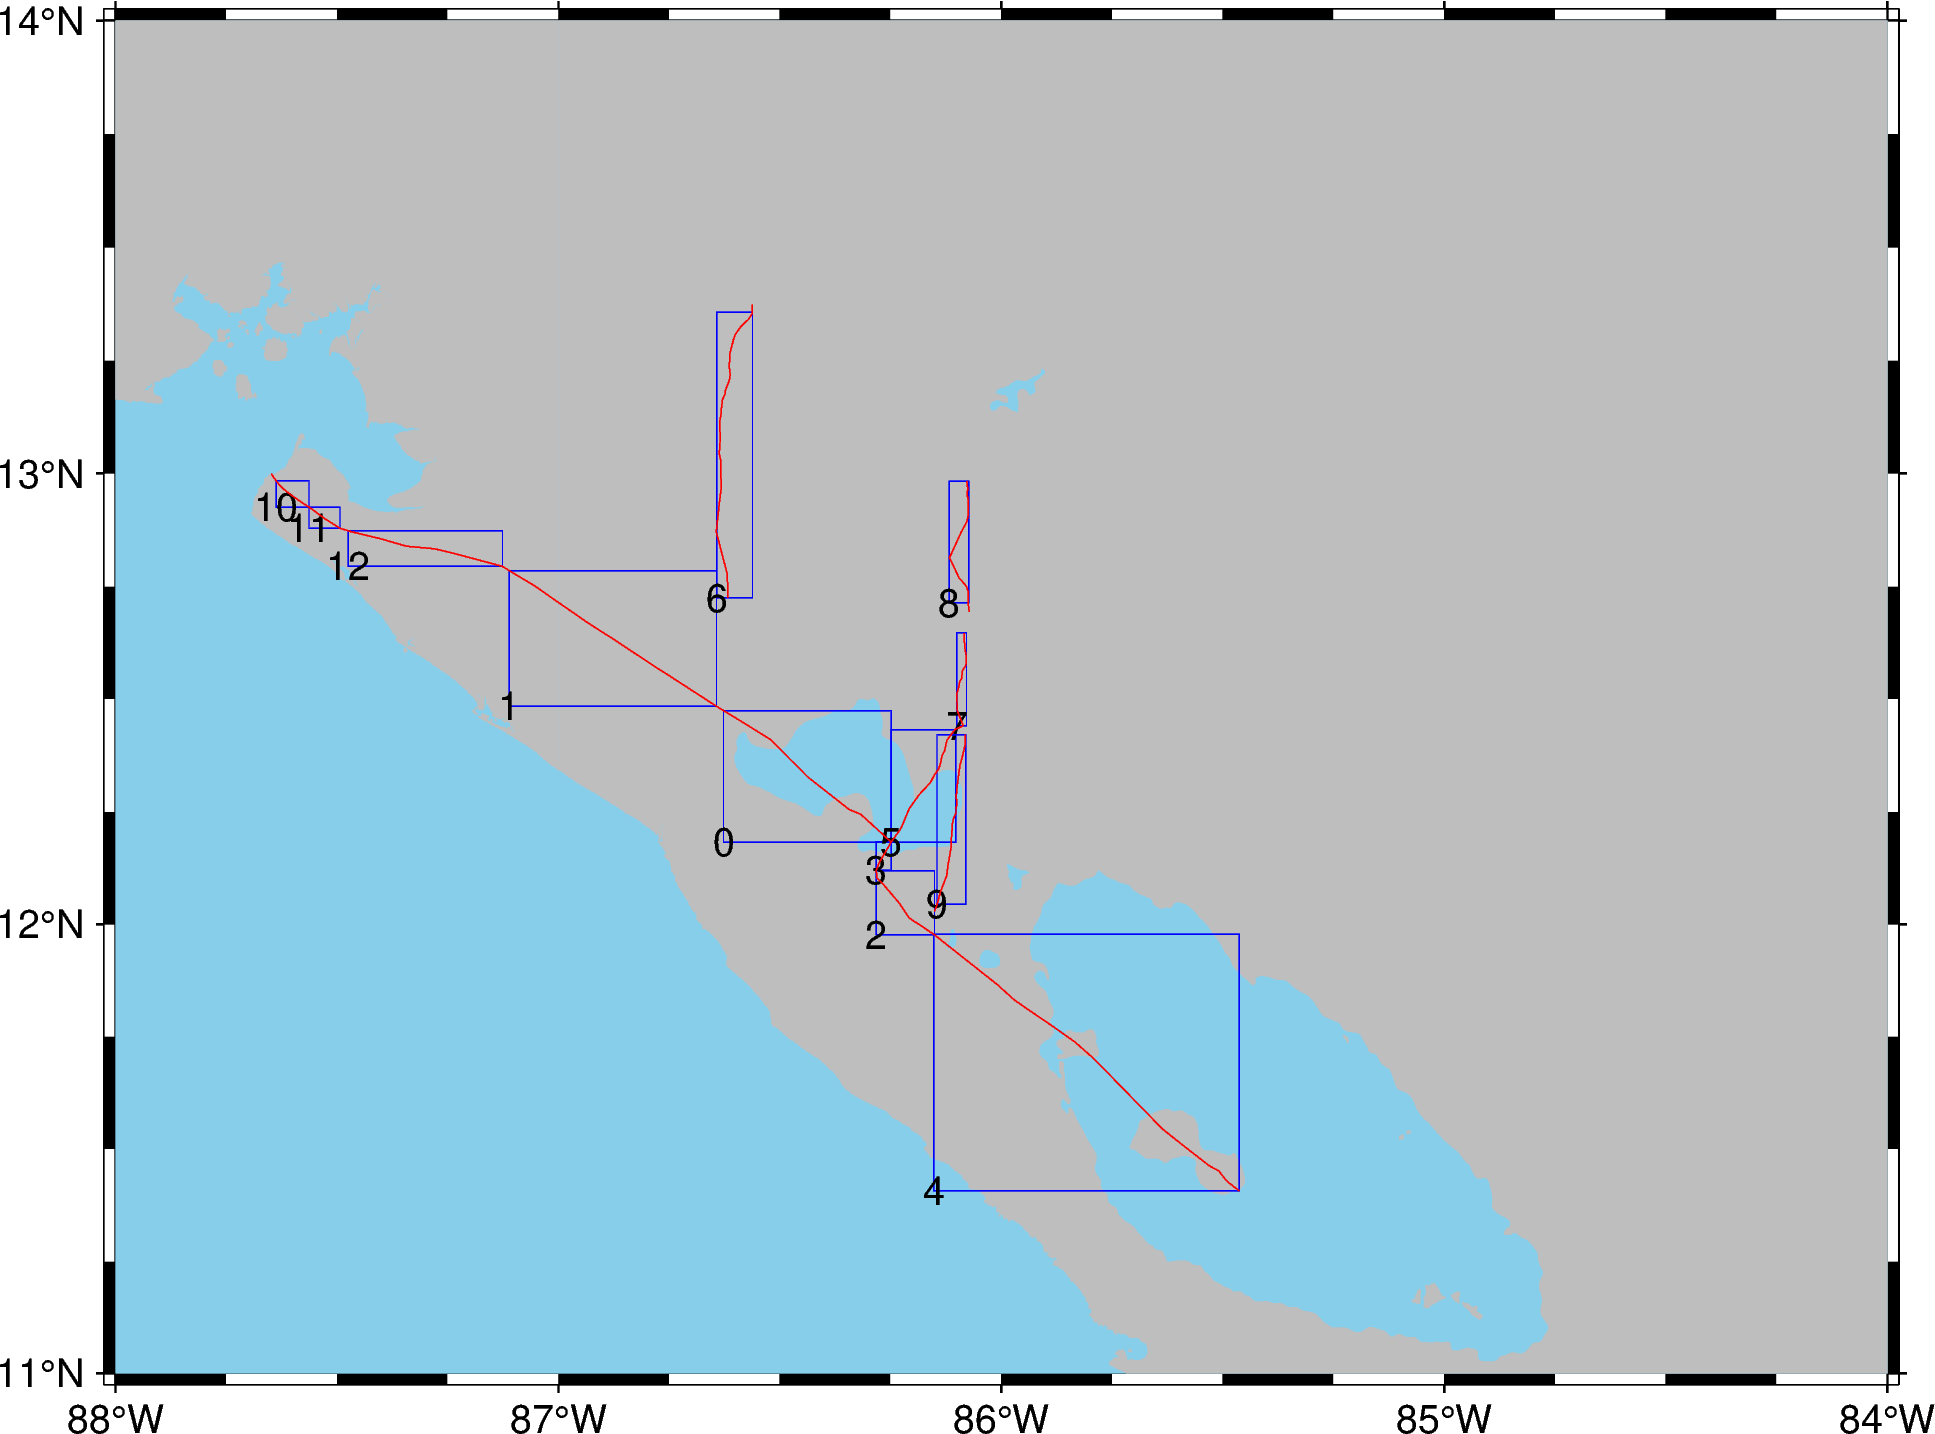

In [65]:
# Plot of the bounding boxes for all the fault surfaces
region = [-125, -70, 0, 35]
region = [-88, -84, 11, 14]
fig = pygmt.Figure()
fig.basemap(region=region, projection="M15c", frame=True)
fig.coast(land="gray", water="skyblue")
for i, bb in enumerate(bbs):
    poly = get_poly_from_bb(bb)
    fig.plot(x=poly[:, 0], y=poly[:, 1], pen="blue", close=True)
    fig.text(x=poly[0, 0], y=poly[0, 1], text=f'{i}')
for trc in traces:
    trc = np.array(trc)
    fig.plot(x=trc[:, 0], y=trc[:, 1], pen="red")
fig.show()

In [15]:
bb_dist_matrix = np.zeros((len(bbs), len(bbs)))
for i in range(len(bbs)):
    for j in range(i+1, len(bbs)):
        bb_dist_matrix[i, j] = get_bb_distance(bbs[i], bbs[j])
np.set_printoptions(linewidth=110)    
print(np.array_str(bb_dist_matrix, precision=1, suppress_small=True))

[[  0.    2.    7.1   0.   25.1   0.   27.8  16.1  30.2  11.3 113.2 104.1  64.8]
 [  0.    0.   56.4  51.5  77.5  43.2   0.1  58.9  56.9  54.5  51.4  42.7   2. ]
 [  0.    0.    0.    0.1   0.    7.   73.8  36.1  66.2   0.6 165.4 156.2 118.5]
 [  0.    0.    0.    0.   18.9   0.   67.4  32.9  60.8  11.3 161.7 152.5 114.1]
 [  0.    0.    0.    0.    0.   22.8  94.2  51.4  81.9   7.4 185.9 176.7 139.4]
 [  0.    0.    0.    0.    0.    0.   47.    0.9  31.3   0.  152.7 143.8 103.4]
 [  0.    0.    0.    0.    0.    0.    0.   50.7  48.2  56.4  99.9  92.3  52.5]
 [  0.    0.    0.    0.    0.    0.    0.    0.    7.4   2.2 161.6 153.2 112.5]
 [  0.    0.    0.    0.    0.    0.    0.    0.    0.   32.6 156.8 149.2 109.4]
 [  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  163.7 154.8 114.3]
 [  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   11.2]
 [  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    2.1]
 [  0.    0.    0.    0.    

## Compute links between faults 

In [20]:
# Checking the number of sections at edges
for i in range(len(bbs)):
    iter_sec = iter_sections(surfs[i].mesh, sections_ul[i], nc_strike, nc_dip)  
    sections0, is_edge0 = [s for s in iter_sec]
    print(i, np.sum(is_edge0))

0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1
12 1


In [34]:
@jit
def get_min_distance(lon1, lat1, dep1, lon2, lat2, dep2):
    """
    Computes the minimum distance between two meshes. Assumes the coordinates 
    are in radians. Reuses code available here: 
    """
    
    lo1r = lon1.flatten() * PI / 180.0
    la1r = lat1.flatten() * PI / 180.0
    lo2r = lon2.flatten() * PI / 180.0
    la2r = lat2.flatten() * PI / 180.0
    de1f = dep1.flatten()
    de2f = dep2.flatten()
    
    mind = 1e100
    for lon, lat, dep in zip(lo1r, la1r, de1f):

        hdists = np.arcsin(np.sqrt(
            np.sin((lat - la2r) / 2.0) ** 2 +
            np.cos(lat) * np.cos(la2r) * np.sin((lon - lo2r) / 2.0) ** 2
        ))
        vdists = dep - de2f
        dists = np.sqrt(hdists ** 2 + vdists ** 2)
        mind = np.min(np.array([mind, np.min(dists)])) 
        
    return mind * 2. * EARTH_RADIUS

In [99]:
tmp_links = []

for i in range(len(bbs)):
    iter_sec = iter_sections(surfs[i].mesh, sections_ul[i], nc_strike, nc_dip)
    sections0, is_edge0 = [s for s in iter_sec]
    
    for j in range(len(bbs)):
        if bb_dist_matrix[i, j] < general_interaction_distance:
            iter_sec = iter_sections(
                surfs[j].mesh, sections_ul[j], nc_strike, nc_dip)
            sections1, is_edge1 = [s for s in iter_sec]
            
            for i0 in range(len(sections0)):
                for i1 in range(len(sections1)):
                    
                    if is_edge0[i0] or is_edge1[i1]: 
                        m0 = sections0[i0]
                        m1 = sections1[i1]
                        mind = get_min_distance(m0.lons, m0.lats, m0.depths,
                                                m1.lons, m1.lats, m1.depths)
                        
                        # The first section in the list is the one at the edge
                        if mind < interaction_distance:
                            if is_edge0[i0]:
                                tmp_links.append([i, j, i0, i1, mind])
                            else:
                                tmp_links.append([j, i, i1, i0, mind])

tmp_links = np.array(tmp_links)                                
links = np.zeros(len(tmp_links), dtype=[('fault1', 'i4'), 
                                        ('fault2', 'i4'), 
                                        ('section1', 'i4'),
                                        ('section2', 'i4'),
                                        ('mindist', 'f4')])
links['fault1'] = tmp_links[:, 0]
links['section1'] = tmp_links[:, 1]
links['fault2'] = tmp_links[:, 2]
links['section2'] = tmp_links[:, 3]

In [140]:
def create_geojson_linked_sections(links, surfs):

    cnt = 0
    for i in range(links.shape[0]):
        if cnt < 10:
            print(links['fault1'][i])
        print(links['fault1'][i],links['section1'][i])
        tmp = sections_ul[links['fault1'][i]][links['section1'][i]]
        # sec_ul = np.array()
        #sec0 = get_section(links[0], sec_ul, nc_strike, nc_dip)
        #pol0 = get_section_polygon(sec0.lons, sec0.lats, sec0.depths)
        
        cnt += 1
        
        

In [141]:
create_geojson_linked_sections(links, surfs)

0
0 0
0
0 0
0
0 0
0
0 0
0
0 0
1
1 0
1
1 0
0
0 3
0
0 3
0
0 3
0 5
0 5
5 0
1 0
1 0
1 1
1 1
1 1
1 1
1 1
12 1
12 1
2 2
2 2
2 2
2 2
2 2
3 2
3 2
2 4
2 4
3 0
0 3
0 3
3 2
3 2
3 3


IndexError: list index out of range

In [ ]:
get_section_polygon(lons, lats, deps)